# Wind farm integration

An example of a wind farm offering firm power by estimating the expected wind resource and then using a MPC to jointly optimize control of a small gas turbine and storage.

In [1]:
%matplotlib inline
import datetime
import pandas as pd
import matplotlib
import numpy as np
import cvxpy as cvx
from matplotlib import pyplot as plt

# import local copy of cvxpower
import os
import sys
from cvxpower import *

matplotlib.rc("figure", figsize=(16,6))
matplotlib.rc("lines", linewidth=2)
#matplotlib.rc("font", serif='Computer Modern Roman')
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)

graphdir = './'
figsize=(8,5)

## TODOs

- keep simplifying the code. it must become much easier to read!
- make a cell at the start with ALL the constants/parameters and their units!
- make better plot/comparisons
- test on two separate weeks? or on the whole year...

## Load predictive model 

In [2]:
baseline = pd.read_pickle('wind_baseline.pickle')
autoreg_residual_params = pd.read_pickle('residual_params.pickle')
sigma_residual_errors = pd.read_pickle('sigma_epsilon.pickle')
train = pd.read_pickle('wind_power_train.pickle')
test = pd.read_pickle('wind_power_test.pickle')
p_wind = pd.concat([train,test])
del train
del test

## Set constants and test period

/home/nick/software/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


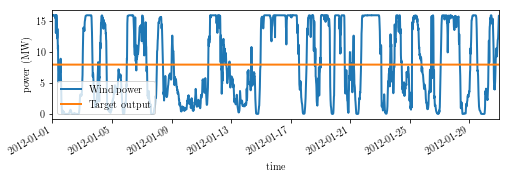

In [3]:
# CONSTANTS
storage_capacity = 50 # MWh
initial_storage = storage_capacity // 2
battery_charge_max = storage_capacity /10. # a full charge in 10 hours
battery_discharge_max = storage_capacity /10. # a full discharge in 10 hours
wind_power_max = 16.  # TODO delete?
wind_power_min = 0.  # TODO delete?

gas_power_max = 12  #MW
gas_power_min = 0.01 #MW
gas_alpha = .1
gas_beta = 20.

# len of each time interval, in hours
len_interval = (baseline.index[1] - baseline.index[0]).seconds/3600
intervals_per_day = int(24 / len_interval)

# analysis horizon
T = intervals_per_day * 31

# we test on the first off-sample month
sim_start_time = 70080 # Timestamp('2012-01-01 00:00:00')
sim_end_time = sim_start_time + T

assert len(baseline) > sim_end_time
assert baseline.index[sim_start_time].year >= 2012 # out of sample

MPC_final_energy_price = 0 / len_interval

#wind_power_available = test[target_output.index]

target_output = pd.Series(data= 8., #baseline[sim_start_time:sim_end_time].mean(),
                          index=baseline[sim_start_time:sim_start_time + 2*T].index)

#p_wind[sim_start_time:sim_end_time].plot(figsize=(12,3), label='Wind power')
plt.figure(figsize=(8,3))
plt.subplot2grid((4,1), (0,0), rowspan=3)
y = p_wind[sim_start_time:sim_end_time]
plt.plot(y.index, y.values, label='Wind power')
target_output[:T].plot(label='Target output')
plt.gca().set_xlim(['01-01-2012', '01-31-2012'])
plt.ylabel('power (MW)')
plt.xlabel('time')

plt.legend(loc='lower left')
plt.savefig('wind_data.pdf')

### Cost of MWh produced by gas turbine 

Text(0, 0.5, '\\$ / MWh')

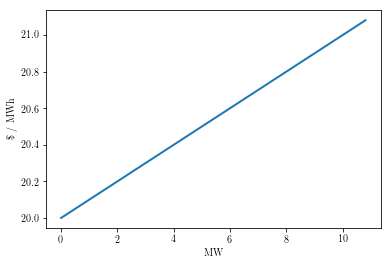

In [4]:
def cost_per_unit(power):
    return (gas_alpha * power**2 + gas_beta * power)/power

x = np.arange(gas_power_min, gas_power_max, gas_power_max/10)
plt.plot(x, cost_per_unit(x))
plt.xlabel('MW')
plt.ylabel('\$ / MWh')

## Prescient DOPF

In [5]:
def make_network(T, K):
    """Define network and parameters for data."""
    target_output = Parameter((T,K))
    wind_power_available = Parameter((T,K))
    initial_storage = Parameter((1,1))
    final_energy_price = Parameter((1,1))
    final_storage = Parameter((1,1))
    out = FixedLoad(power = target_output, name="Target output")
    wind_gen = Generator(alpha=0, beta=0, power_min=0, 
                         power_max=wind_power_available, name="Wind generator")
    gas_gen = Generator(alpha=gas_alpha, beta=gas_beta, 
                        power_min=gas_power_min, power_max=gas_power_max, name="Gas generator",
                       len_interval = len_interval)
    storage = Storage(discharge_max=battery_discharge_max, charge_max=battery_charge_max, 
                      energy_max=storage_capacity, 
                      energy_init = initial_storage, 
                      #energy_final = final_storage,
                     len_interval = len_interval,
                     final_energy_price = np.matrix(MPC_final_energy_price))
    net = Net([wind_gen.terminals[0],
               gas_gen.terminals[0],
               storage.terminals[0],
               out.terminals[0]])
    dopf_network = Group([wind_gen, gas_gen, storage, out], [net])
    dopf_network.init_problem(time_horizon=T, num_scenarios = K)
    return target_output, wind_power_available, initial_storage, final_storage, final_energy_price, dopf_network

In [6]:
target_output_par, wind_power_available_par, initial_storage_par, final_storage_par, final_energy_price, dopf_network = \
    make_network(T, 1)
    
target_output_par.value = np.matrix(target_output[:T]).T
wind_power_available_par.value = np.matrix(p_wind[sim_start_time:sim_end_time]).T
initial_storage_par.value = np.matrix(initial_storage)
final_storage_par.value = np.matrix(initial_storage)
final_energy_price.value = np.matrix(0.)

cost_dopf = dopf_network.problem.solve(solver='ECOS', verbose=False)
results_dopf = dopf_network.optimize(solver='ECOS', verbose=False, time_horizon=T)

/home/nick/software/anaconda3/lib/python3.5/site-packages/cvxpy-1.0.8-py3.5-linux-i686.egg/cvxpy/problems/problem.py:614: RuntimeWarning: overflow encountered in long_scalars
  if self.max_big_small_squared < big*small**2:
/home/nick/software/anaconda3/lib/python3.5/site-packages/cvxpy-1.0.8-py3.5-linux-i686.egg/cvxpy/problems/problem.py:615: RuntimeWarning: overflow encountered in long_scalars
  self.max_big_small_squared = big*small**2


In [7]:
def print_and_plot_stats(wind_power_avail, wind_power_used, gas_power, output, cost):
    assert len(output) == len(wind_power_avail)
    assert len(output) == len(wind_power_used)
    assert len(output) == len(gas_power)

    plt.figure(figsize=(9,3.5))
    plt.subplot2grid((10,1), (0,0), rowspan=9)
    plt.plot(wind_power_avail.index, wind_power_avail.values, label='avail.', alpha=.8)
    pd.Series(data = wind_power_used, 
              index = wind_power_avail.index).plot(label='used', alpha=.8)
    #output.plot(label='target', style='--', color='k', alpha=.8)
    plt.legend(loc='lower left')
    plt.gca().set_xlim(['01-01-2012', '01-31-2012'])
    plt.ylabel('Power (MW)')
    plt.xlabel('time')
    #plt.gcf().autofmt_xdate()
    plt.savefig('wind_curtailment.pdf')

    total_output = sum(output)/len(output) 
    total_wind_power_avail = sum(wind_power_avail)/len(output)
    total_gas_gen = sum(gas_power)/len(output)

    print('(Values are daily averages.)\n')
    print('Energy sold:\t\t%.2f MWh\nWind energy avail.:\t%.2f MWh\nGas gener. output:\t%.2f MWh\nWind energy used:\t%.2f MWh\nWind energy lost:\t%.2f MWh' % (
        24*total_output,
        24*total_wind_power_avail,
        24*total_gas_gen,
        24*np.mean(wind_power_used),
        24*(total_wind_power_avail - np.mean(wind_power_used))
    ))

    print('Cost of gas generated energy:  $%.2f' % (24 / len_interval * cost / (len(output))))

(Values are daily averages.)

Energy sold:		192.00 MWh
Wind energy avail.:	202.36 MWh
Gas gener. output:	38.72 MWh
Wind energy used:	152.49 MWh
Wind energy lost:	49.87 MWh
Cost of gas generated energy:  $3157.82
<class 'list'>
<class 'numpy.ndarray'>
Status: optimal
Terminal                  Power
--------                  -----
Gas generator[0]          -1.61
Storage[0]                -0.03
Target output[0]           8.00
Wind generator[0]         -6.35

Net                       Price
---                       -----
Net                     10.6510

Device                  Payment
------                  -------
Wind generator        -97403.43
Storage               -56693.02
Gas generator         -99481.75
Target output         253578.21

Power and price are averages over the time horizon. Payment is total.



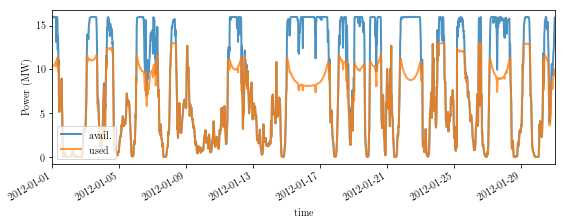

In [8]:
wind_gen, gas_gen, storage = dopf_network.devices[0:3]

print_and_plot_stats(wind_power_avail = p_wind[sim_start_time:sim_end_time], 
                     wind_power_used = -dopf_network.results.power[(wind_gen, 0)].flatten(), 
                     gas_power = -dopf_network.results.power[(gas_gen,0)], 
                     output = target_output[:T], 
                     cost = cost_dopf)
print(results_dopf)

In [9]:
def plot(results, target_output, energy_stored, methodname):
    
    fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(9, 6))
    plt.subplots_adjust(hspace=0.075)
    
    ax[0].set_ylabel('power (MW)')
    powers = [p for p in results.power.items()]
    names = [dt[0].name for dt, _ in powers]
    idx = np.argsort(names)
    powers = [powers[idx[i]] for i in range(len(powers))]
    for device_terminal, value in powers:
        label = "%s[%d]" % (device_terminal[0].name,
                            device_terminal[1])
        ax[0].plot(target_output.index, value, label=label)
    #ax[0].legend(loc="upper left")
    ax[0].set_xlim(['01-01-2012', '01-31-2012'])
    ax[0].tick_params(axis="x", which="both", bottom="off", top="off",
                  labelbottom="off", left="off", right="off", labelleft="off")

    ax[0].legend(['gen.', 'batt.', 'target', 'wind'], loc='lower left')
    
    ax[1].plot(target_output.index, energy_stored)
    ax[1].set_ylabel('Energy (MWh)')
    ax[1].set_xlim(['01-01-2012', '01-31-2012'])
    ax[1].set_ylim([0, 50])
    ax[1].tick_params(axis="x", which="both", bottom="off", top="off",
                  labelbottom="off", left="off", right="off", labelleft="off")
    
    ax[2].set_ylabel("Price (\$/MWh)")
    for net, value in results.price.items():
        price = value/len_interval
        ax[2].plot(target_output.index, price, label=net.name)
    ax[2].tick_params(axis="x", which="both", bottom="off", top="off",
                  labelbottom="off", left="off", right="off", labelleft="off")
    ax[2].set_xlim(['01-01-2012', '01-31-2012'])

    for device_terminal, value in powers:
        label = "%s[%d]" % (device_terminal[0].name,
                            device_terminal[1])
        ax[3].plot(target_output.index, value*price, label=label)
    ax[3].set_xlim(['01-01-2012', '01-31-2012'])
    ax[3].set_ylabel("Pmnt.\ rate (\$/h)")
    
    plt.xlabel('time')
    plt.savefig(graphdir + 'wind_%s_results.pdf' % methodname)

/home/nick/software/anaconda3/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


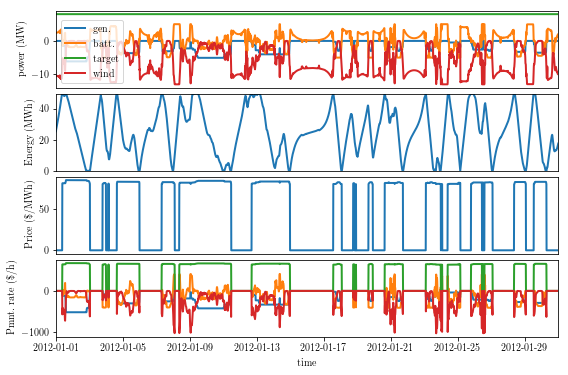

In [10]:
wind_gen, gas_gen, storage = dopf_network.devices[0:3]
plot(dopf_network.results, baseline[sim_start_time:sim_end_time], storage.energy.value, 'dopf')

## Prescient MPC 

In [11]:
T_MPC = intervals_per_day

energy_stored = np.empty(T)

target_output_MPC, wind_power_available_MPC, initial_storage_MPC, final_storage_MPC, final_energy_price, MPC_network = \
    make_network(T_MPC, 1)
    
initial_storage_MPC.value = np.matrix(initial_storage)
final_storage_MPC.value = np.matrix(initial_storage)
final_energy_price.value = np.matrix(MPC_final_energy_price)

def make_forecasts(t):
    target_output_MPC.value = np.matrix(target_output[t:t+T_MPC]).T
    wind_power_available_MPC.value = np.matrix(p_wind[sim_start_time+t:sim_start_time+t+T_MPC]).T
    
def implement(t):
    energy_stored[t] = MPC_network.devices[2].energy.value[0]
    initial_storage_MPC.value = np.matrix(energy_stored[t])
    #final_storage_MPC.value = np.matrix(energy_stored[t]) # change this to change MPC behavior
    
cost_prescient_MPC, prescient_MPC_results = \
    run_mpc(MPC_network, T, make_forecasts, implement, verbose = False, solver='ECOS')

100%|██████████| 2976/2976 [12:45<00:00,  3.99it/s]


(Values are daily averages.)

Energy sold:		192.00 MWh
Wind energy avail.:	202.36 MWh
Gas gener. output:	39.52 MWh
Wind energy used:	152.52 MWh
Wind energy lost:	49.83 MWh
Cost of gas generated energy:  $3223.84
<class 'list'>
<class 'numpy.ndarray'>
Status: optimal
Terminal                  Power
--------                  -----
Gas generator[0]          -1.65
Storage[0]                 0.00
Target output[0]           8.00
Wind generator[0]         -6.36

Net                       Price
---                       -----
Net                     10.8929

Device                  Payment
------                  -------
Storage               -55497.59
Wind generator       -102255.04
Gas generator        -101585.84
Target output         259338.47

Power and price are averages over the time horizon. Payment is total.



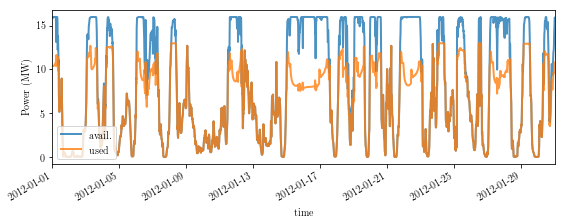

In [12]:
wind_gen, gas_gen, storage = MPC_network.devices[0:3]

print_and_plot_stats(wind_power_avail =  p_wind[sim_start_time:sim_end_time], 
                     wind_power_used = -prescient_MPC_results.power[(wind_gen, 0)].flatten(), 
                     gas_power = -prescient_MPC_results.power[(gas_gen,0)].flatten(), 
                     output =  target_output[:T],
                     cost = cost_prescient_MPC)
print(prescient_MPC_results)

/home/nick/software/anaconda3/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


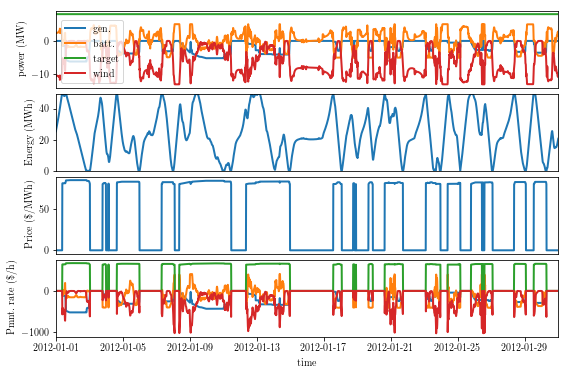

In [13]:
plot(prescient_MPC_results,  baseline[sim_start_time:sim_end_time], energy_stored, 'presc_mpc')

## MPC with baseline and residual AR

In [14]:
T_MPC = intervals_per_day

energy_stored = np.empty(T)

target_output_MPC, wind_power_available_MPC, initial_storage_MPC, final_storage_MPC, final_energy_price, MPC_network = \
    make_network(T_MPC, 1)
    
initial_storage_MPC.value = np.matrix(initial_storage)
final_storage_MPC.value = np.matrix(initial_storage)
final_energy_price.value = np.matrix(MPC_final_energy_price)

def predict_wind(p_wind, baseline, autoreg_residual_params, t, M, L, K = 1):
    past = p_wind[t-M:t]
    past_baseline = baseline[t-M:t]
    fut_baseline = baseline[t:t+L]
    pred = list(reversed(past-past_baseline)) @ autoreg_residual_params
    pred = pd.Series(pred, index=fut_baseline.index)
    pred = np.maximum(wind_power_min, pred + fut_baseline)
    pred = np.minimum(wind_power_max, pred + fut_baseline)
    return pred

def make_forecasts(t):
    target_output_MPC.value = np.matrix(target_output[t:t+T_MPC]).T
    wind_power_available_MPC.value = np.matrix(np.concatenate([
        [p_wind[sim_start_time+t]],
        predict_wind(p_wind, baseline, autoreg_residual_params, sim_start_time+t+1, T_MPC, T_MPC)[:-1]])).T
        
def implement(t):
    energy_stored[t] = MPC_network.devices[2].energy.value[0]
    initial_storage_MPC.value = np.matrix(energy_stored[t])
    #final_storage_MPC.value = np.matrix(energy_stored[t]) # change this to change MPC behavior
    
cost_AR_MPC, AR_MPC_results = \
    run_mpc(MPC_network, T, make_forecasts, implement, verbose = False, solver='ECOS')

100%|██████████| 2976/2976 [14:10<00:00,  3.49it/s]


(Values are daily averages.)

Energy sold:		192.00 MWh
Wind energy avail.:	202.36 MWh
Gas gener. output:	53.16 MWh
Wind energy used:	138.03 MWh
Wind energy lost:	64.33 MWh
Cost of gas generated energy:  $4385.13
<class 'list'>
<class 'numpy.ndarray'>
Status: optimal
Terminal                  Power
--------                  -----
Gas generator[0]          -2.22
Storage[0]                -0.03
Target output[0]           8.00
Wind generator[0]         -5.75

Net                       Price
---                       -----
Net                      9.2121

Device                  Payment
------                  -------
Wind generator        -63964.62
Gas generator        -139695.65
Storage               -15660.83
Target output         219321.10

Power and price are averages over the time horizon. Payment is total.



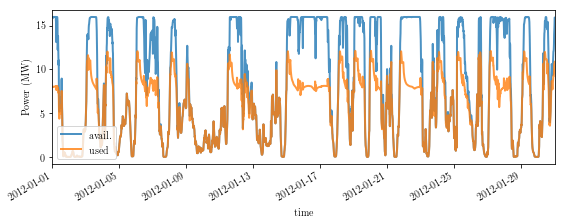

In [15]:
wind_gen, gas_gen, storage = MPC_network.devices[0:3]

print_and_plot_stats(wind_power_avail =  p_wind[sim_start_time:sim_end_time], 
                     wind_power_used = -AR_MPC_results.power[(wind_gen, 0)].flatten(), 
                     gas_power = -AR_MPC_results.power[(gas_gen,0)].flatten(), 
                     output =  target_output[:T],
                     cost = cost_AR_MPC)
print(AR_MPC_results)

/home/nick/software/anaconda3/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


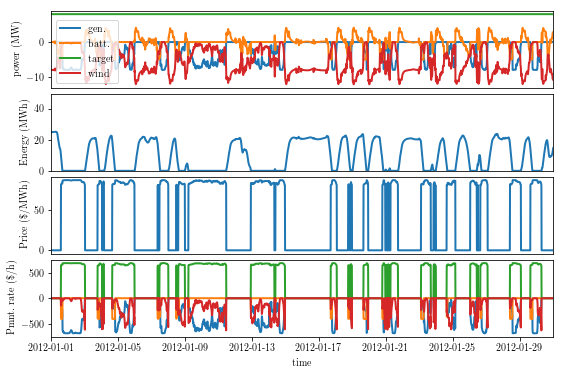

In [16]:
plot(AR_MPC_results,  baseline[sim_start_time:sim_end_time], energy_stored, 'AR_mpc')

### Diagnostic 

In [17]:
# t = sim_start_time

# past = p_wind[t-intervals_per_day:t]
# future = p_wind[t:t+intervals_per_day]

# past_baseline = baseline[t-intervals_per_day:t]
# fut_baseline = baseline[t:t+intervals_per_day]

# past.plot()
# future.plot()

# past_baseline.plot()
# fut_baseline.plot()

# plt.figure()

# (past-  past_baseline).plot()
# (future-  fut_baseline).plot()

# pred = predict_wind(p_wind, baseline, autoreg_residual_params, t, intervals_per_day, intervals_per_day)

# (pred - fut_baseline).plot(style='--')

# plt.figure()
# past.plot()
# future.plot()
# (pred).plot()

## Robust MPC 

In [18]:
T_MPC = intervals_per_day
K = 20

energy_stored = np.empty(T)

target_output_MPC, wind_power_available_MPC, initial_storage_MPC, final_storage_MPC, final_energy_price, MPC_network = \
    make_network(T_MPC, K)
    
initial_storage_MPC.value = np.matrix(initial_storage)
final_storage_MPC.value = np.matrix(initial_storage)
final_energy_price.value = np.matrix(MPC_final_energy_price)


def make_forecasts(t):
    target_output_MPC.value = np.tile(target_output[t:t+T_MPC], (K,1)).T
#     wind_power_available_MPC.value = np.tile(np.concatenate([
#         [p_wind[sim_start_time+t]],
#         predict_wind(p_wind, baseline, autoreg_residual_params, sim_start_time+t+1, T_MPC, T_MPC)[:-1]]),
#                                              (K,1)).T
    # draw scenarios
    scenarios = np.hstack([np.matrix([p_wind[sim_start_time+t]]*K).T,
                           np.random.multivariate_normal(predict_wind(p_wind, baseline, 
                            autoreg_residual_params, sim_start_time+t+1, T_MPC, T_MPC), 
                             sigma_residual_errors, K)[:,:-1]])
    scenarios = np.maximum(wind_power_min, scenarios)
    scenarios = np.minimum(wind_power_max, scenarios)
    wind_power_available_MPC.value = scenarios.T
    
        
def implement(t):
    energy_stored[t] = MPC_network.devices[2].energy.value[0,0]
    initial_storage_MPC.value = np.matrix(energy_stored[t])
    
cost_robust_MPC, MPC_robust_results = \
    run_mpc(MPC_network, T, make_forecasts, implement, verbose = False, solver='ECOS')

  0%|          | 0/2976 [00:00<?, ?it/s]/home/nick/software/anaconda3/lib/python3.5/site-packages/cvxpy-1.0.8-py3.5-linux-i686.egg/cvxpy/problems/problem.py:614: RuntimeWarning: overflow encountered in long_scalars
  if self.max_big_small_squared < big*small**2:
/home/nick/software/anaconda3/lib/python3.5/site-packages/cvxpy-1.0.8-py3.5-linux-i686.egg/cvxpy/problems/problem.py:615: RuntimeWarning: overflow encountered in long_scalars
  self.max_big_small_squared = big*small**2
100%|██████████| 2976/2976 [3:44:25<00:00,  5.76s/it]  


(Values are daily averages.)

Energy sold:		192.00 MWh
Wind energy avail.:	202.36 MWh
Gas gener. output:	46.72 MWh
Wind energy used:	144.47 MWh
Wind energy lost:	57.88 MWh
Cost of gas generated energy:  $3850.34
<class 'list'>
<class 'numpy.ndarray'>
Status: optimal
Terminal                  Power
--------                  -----
Gas generator[0]          -1.95
Storage[0]                -0.03
Target output[0]           8.00
Wind generator[0]         -6.02

Net                       Price
---                       -----
Net                      8.9339

Device                  Payment
------                  -------
Wind generator        -61592.46
Storage               -28556.85
Target output         212699.25
Gas generator        -122549.95

Power and price are averages over the time horizon. Payment is total.

optimal


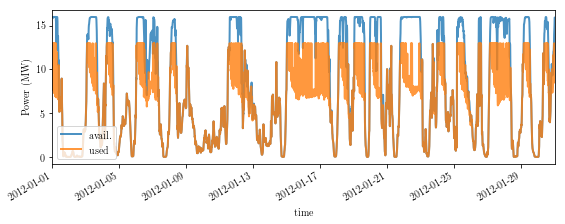

In [19]:
wind_gen, gas_gen, storage = MPC_network.devices[0:3]

print_and_plot_stats(wind_power_avail =  p_wind[sim_start_time:sim_end_time], 
                     wind_power_used = -MPC_robust_results.power[(wind_gen, 0)].flatten(), 
                     gas_power = -MPC_robust_results.power[(gas_gen,0)].flatten(), 
                     output =  target_output[:T],
                     cost = cost_robust_MPC)
print(MPC_robust_results)
print(MPC_robust_results.status)

/home/nick/software/anaconda3/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


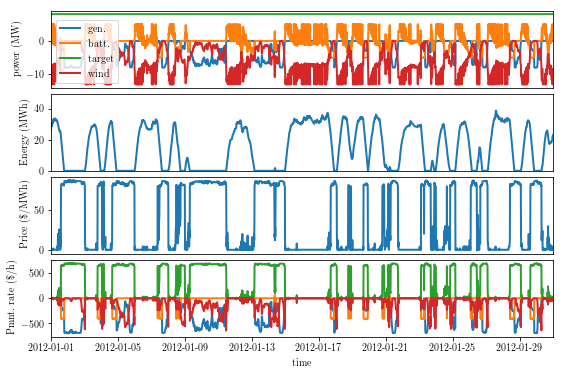

In [20]:
plot(MPC_robust_results,  baseline[sim_start_time:sim_end_time], energy_stored, 'robust_mpc')